## Funções

In [1]:
def limpar_dataset(arquivo, colunas_para_verificar=None, colunas_para_excluir=None):
    """
    Limpa o dataset removendo linhas com dados faltantes nas colunas especificadas.

    Parâmetros:
    - arquivo: str, nome do arquivo CSV a ser carregado.
    - colunas_para_verificar: list, lista de colunas para verificar dados faltantes. Se None, verifica todas as colunas.
    - colunas_para_excluir: list, lista de colunas a serem excluídas do dataset. Se None, não exclui colunas.
    """
    df = pd.read_csv(arquivo)

    # Transformar colunas month e year em datetime e gerar uma coluna data juntando mês e ano
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

    # Listar todas as colunas se nenhuma coluna específica for fornecida
    if colunas_para_verificar is None:
        colunas_para_verificar = df.columns.tolist()

    # Verificar a quantidade de dados faltantes em cada coluna antes da limpeza
    print("Dados faltantes antes da limpeza:")
    print(df.isnull().sum())

    # Excluir linhas com dados faltantes nas colunas especificadas
    df_limpo = df.dropna(subset=colunas_para_verificar)

    # Garantir que a coluna 'date' seja do tipo datetime no DataFrame limpo
    df_limpo['date'] = pd.to_datetime(df_limpo['date'])

    # Excluir colunas especificadas
    if colunas_para_excluir is not None:
        df_limpo = df_limpo.drop(columns=colunas_para_excluir)

    # Verificar a quantidade de dados faltantes após a remoção de linhas
    print("\nDados faltantes após a limpeza:")
    print(df_limpo.isnull().sum())

    # Salvar o DataFrame limpo
    df_limpo.to_csv(f"{arquivo.rstrip('.csv')}_limpo.csv", index=False)
    print(f"\nDataset limpo salvo como: {arquivo.rstrip('.csv')}_limpo.csv")

In [2]:
def plot_mapa(df, rotulo, titulo, legenda, ax):
    """
    Plota um mapa dos territórios brasileiros.

    Parâmetros:
    - df: pd.DataFrame, dataframe do geobr.
    - rotulo: str, nome da featue do dataframe a qual se deseja plotar.
    - titulo: str, nome do título do gráfico.
    - legenda: str, nome do título da legenda.
    """
    plt.rcParams.update({"font.size": 6})
    
    df.plot(
        column=rotulo,
        cmap="RdBu_r",
        legend=True,
        legend_kwds={
            "label": legenda,
            "orientation": "vertical",
            "shrink": 0.4
        },
        ax=ax,
    )
    
    ax.set_title(titulo, fontweight=800, fontsize=8)
    
    ax.axis("off")
    plt.tight_layout()

def plot_serie_temporal(df, rotulo, coluna_tempo, coluna_legenda, titulo, titulo_legenda, xlabel, ylabel, ax):
    """
    Plota um gráfico de série temporal.

    Parâmetros:
    - df: pd.DataFrame, dataframe.
    - rotulo: str, nome da feature do dataframe a qual se deseja plotar.
    - coluna_tempo: str, nome da feature do dataframe referente ao eixo x (tempo).
    - coluna_legenda: str, nome da feature do dataframe referente à legenda.
    - titulo: str, nome do título do gráfico.
    - titulo_legenda: str, nome do título da legenda.
    - xlabel: str, nome do título do eixo x.
    - ylabel: str, nome do título do eixo y.
    - ax: plt.ax, axis do matplotlib.
    """
    plt.rcParams.update(plt.rcParamsDefault)
    
    for el in df[coluna_legenda].unique():
        ax.plot(
            df[coluna_tempo].unique(),
            df[df[coluna_legenda] == el][rotulo],
            label=el,
            marker="o",
            markersize=3
        )
    
    ax.legend(title=titulo_legenda)
    
    ax.set_title(titulo, fontweight=800, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.set_xticklabels(df[coluna_tempo].unique(), rotation=45)

###
## Imports e limpeza dos dados

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import geobr

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA

import warnings

warnings.filterwarnings("ignore")

In [4]:
with open("dicionario_dados.txt", "r", encoding="utf8") as arquivo:
    lines = arquivo.readlines()

dicionario_dados = {}

for i, line in enumerate(lines):
    if i > 1:
        dados = [text.strip() for text in line.split("|")][1:-1]
        dicionario_dados[dados[0]] = dados[-1]

In [5]:
dicionario_dados = pd.DataFrame(dicionario_dados.items(), columns=["variavel", "descricao"])
display(dicionario_dados)

,variavel,descricao
0,micro_code,Número de ID único dado pelo IBGE a cada micro...
1,micro_name,Nome de cada microrregião
2,micro_name_ibge,Nome de cada microrregião (das fontes do IBGE)
3,meso_code,Número de ID único dado pelo IBGE a cada mesor...
4,meso_name,Nome de cada mesorregião
5,state_code,Número de ID único dado pelo IBGE a cada estado
6,state_name,Nome do estado
7,region_code,Código da região
8,region_name,Nome da região
9,biome_code,Código do bioma


In [6]:
df_dengue = pd.read_csv("data_2000_2019.csv")
df_dengue.head(10)

,micro_code,micro_name,micro_name_ibge,meso_code,meso_name,state_code,state_name,region_code,region_name,biome_code,...,time,dengue_cases,population,pop_density,tmax,tmin,pdsi,urban,water_network,water_shortage
0,11001,Porto Velho,PORTO VELHO,1101,Madeira-Guaporé,11,Rondônia,1,North,5,...,1,NaN,NaN,NaN,30.544556,21.751202,-1.790602,85.20,33.57,0.2245
1,11002,Guajar<e1>-Mirim,GUAJARÁ-MIRIM,1101,Madeira-Guaporé,11,Rondônia,1,North,5,...,1,NaN,NaN,NaN,31.005884,21.641306,0.629408,72.31,27.43,0.0873
2,11003,Ariquemes,ARIQUEMES,1102,Leste Rondoniense,11,Rondônia,1,North,5,...,1,NaN,NaN,NaN,30.444357,21.492065,-3.455422,66.91,27.76,0.1871
3,11004,Ji-Paran<e1>,JI-PARANÁ,1102,Leste Rondoniense,11,Rondônia,1,North,5,...,1,NaN,NaN,NaN,30.458706,21.111828,-1.586286,68.68,32.23,0.2381
4,11005,Alvorada D'Oeste,ALVORADA D'OESTE,1102,Leste Rondoniense,11,Rondônia,1,North,5,...,1,NaN,NaN,NaN,30.616793,21.053421,-0.043228,42.82,21.40,0.2837
5,11006,Cacoal,CACOAL,1102,Leste Rondoniense,11,Rondônia,1,North,5,...,1,NaN,NaN,NaN,31.070950,21.242662,1.675866,66.43,45.39,0.3104
6,11007,Vilhena,VILHENA,1102,Leste Rondoniense,11,Rondônia,1,North,5,...,1,NaN,NaN,NaN,31.021709,20.951286,1.622710,82.83,79.22,0.1601
7,11008,Colorado Oeste,COLORADO DO OESTE,1102,Leste Rondoniense,11,Rondônia,1,North,5,...,1,NaN,NaN,NaN,31.530151,21.251291,-0.529292,65.39,38.42,0.1397
8,12001,Cruzeiro do Sul,CRUZEIRO DO SUL,1201,Vale Do Juruá,12,Acre,1,North,5,...,1,NaN,NaN,NaN,31.401978,21.892986,-0.799765,57.45,45.12,0.2444
9,12002,Tarauac<e1>,TARAUACÁ,1201,Vale Do Juruá,12,Acre,1,North,5,...,1,NaN,NaN,NaN,30.917717,21.772980,1.012203,51.19,27.53,0.3492


In [7]:
colunas_para_excluir = ['micro_code','month','year','micro_name',
                        'meso_code','meso_name','state_code',
                        'region_code','biome_code','biome_name',
                        'ecozone_code']

limpar_dataset("data_2000_2019.csv", colunas_para_excluir=colunas_para_excluir)

Dados faltantes antes da limpeza:
micro_code            0
micro_name            0
micro_name_ibge       0
meso_code             0
meso_name             0
state_code            0
state_name            0
region_code           0
region_name           0
biome_code            0
biome_name            0
ecozone_code          0
ecozone_name          0
main_climate          0
month                 0
year                  0
time                  0
dengue_cases       6696
population         6696
pop_density        6696
tmax                  0
tmin                  0
pdsi                240
urban                 0
water_network         0
water_shortage        0
date                  0
dtype: int64

Dados faltantes após a limpeza:
micro_name_ibge    0
state_name         0
region_name        0
ecozone_name       0
main_climate       0
time               0
dengue_cases       0
population         0
pop_density        0
tmax               0
tmin               0
pdsi               0
urban              0

In [8]:
df_dengue = pd.read_csv("data_2000_2019_limpo.csv")
df_dengue.head(5)

,micro_name_ibge,state_name,region_name,ecozone_name,main_climate,time,dengue_cases,population,pop_density,tmax,tmin,pdsi,urban,water_network,water_shortage,date
0,PORTO VELHO,Rondônia,North,Amazon,AM,13,267.0,426640.0,6.503234,30.180363,21.471796,-0.311743,85.20,33.57,0.2245,2001-01-01
1,GUAJARÁ-MIRIM,Rondônia,North,Amazon,AM,13,12.0,61321.0,1.504577,30.369087,21.300480,-0.803746,72.31,27.43,0.0873,2001-01-01
2,ARIQUEMES,Rondônia,North,Amazon,AM,13,2.0,143809.0,5.903734,30.084492,21.183846,-0.022145,66.91,27.76,0.1871,2001-01-01
3,JI-PARANÁ,Rondônia,North,Amazon,AM,13,93.0,306896.0,12.241386,29.946037,20.736881,-0.269979,68.68,32.23,0.2381,2001-01-01
4,ALVORADA D'OESTE,Rondônia,North,Amazon,AM,13,1.0,74460.0,4.658250,29.965841,20.655041,-1.247326,42.82,21.40,0.2837,2001-01-01


In [9]:
estados_ufs = {
    "Acre": "AC",
    "Alagoas": "AL",
    "Amapá": "AP",
    "Amazonas": "AM",
    "Bahia": "BA",
    "Ceará": "CE",
    "Distrito Federal": "DF",
    "Espírito Santo": "ES",
    "Goiás": "GO",
    "Maranhão": "MA",
    "Mato Grosso": "MT",
    "Mato Grosso Do Sul": "MS",
    "Minas Gerais": "MG",
    "Pará": "PA",
    "Paraíba": "PB",
    "Paraná": "PR",
    "Pernambuco": "PE",
    "Piauí": "PI",
    "Roraima": "RR",
    "Rondônia": "RO",
    "Rio De Janeiro": "RJ",
    "Rio Grande Do Norte": "RN",
    "Rio Grande Do Sul": "RS",
    "Santa Catarina": "SC",
    "São Paulo": "SP",
    "Sergipe": "SE",
    "Tocantins": "TO"
}

df_dengue["uf"] = df_dengue["state_name"].apply(lambda estado: estados_ufs[estado])

In [10]:
regioes = {
    "North": "Norte",
    "Northeast": "Nordeste",
    "Southeast": "Sudeste",
    "South": "Sul",
    "Centre-West": "Centro Oeste"
}

df_dengue["region_name"] = df_dengue["region_name"].apply(lambda regiao: regioes[regiao])

In [11]:
biomas = {
    "Amazon": "Amazônia",
    "NE Atlantic Rainforest": "Mata Atlântica - Nordeste",
    "SE Atlantic Rainforest": "Mata Atlântica - Sudeste",
    "S Atlantic Rainforest": "Mata Atlântica - Sul",
}

df_dengue["ecozone_name"] = df_dengue["ecozone_name"].apply(lambda bioma: biomas.get(bioma, bioma))

In [12]:
df_dengue["micro_name_ibge"] = df_dengue['micro_name_ibge'].str.title() + "_" + df_dengue['uf']

In [13]:
df_dengue.head()

,micro_name_ibge,state_name,region_name,ecozone_name,main_climate,time,dengue_cases,population,pop_density,tmax,tmin,pdsi,urban,water_network,water_shortage,date,uf
0,Porto Velho_RO,Rondônia,Norte,Amazônia,AM,13,267.0,426640.0,6.503234,30.180363,21.471796,-0.311743,85.20,33.57,0.2245,2001-01-01,RO
1,Guajará-Mirim_RO,Rondônia,Norte,Amazônia,AM,13,12.0,61321.0,1.504577,30.369087,21.300480,-0.803746,72.31,27.43,0.0873,2001-01-01,RO
2,Ariquemes_RO,Rondônia,Norte,Amazônia,AM,13,2.0,143809.0,5.903734,30.084492,21.183846,-0.022145,66.91,27.76,0.1871,2001-01-01,RO
3,Ji-Paraná_RO,Rondônia,Norte,Amazônia,AM,13,93.0,306896.0,12.241386,29.946037,20.736881,-0.269979,68.68,32.23,0.2381,2001-01-01,RO
4,Alvorada D'Oeste_RO,Rondônia,Norte,Amazônia,AM,13,1.0,74460.0,4.658250,29.965841,20.655041,-1.247326,42.82,21.40,0.2837,2001-01-01,RO


In [14]:
df_dengue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126996 entries, 0 to 126995
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   micro_name_ibge  126996 non-null  object 
 1   state_name       126996 non-null  object 
 2   region_name      126996 non-null  object 
 3   ecozone_name     126996 non-null  object 
 4   main_climate     126996 non-null  object 
 5   time             126996 non-null  int64  
 6   dengue_cases     126996 non-null  float64
 7   population       126996 non-null  float64
 8   pop_density      126996 non-null  float64
 9   tmax             126996 non-null  float64
 10  tmin             126996 non-null  float64
 11  pdsi             126996 non-null  float64
 12  urban            126996 non-null  float64
 13  water_network    126996 non-null  float64
 14  water_shortage   126996 non-null  float64
 15  date             126996 non-null  object 
 16  uf               126996 non-null  obje

###
## EDA

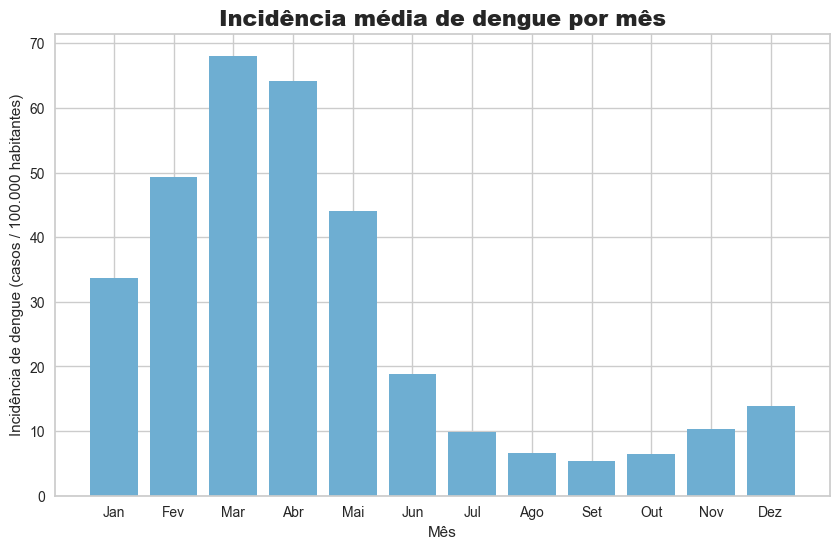

In [15]:
# Calcular a incidência de dengue por 100.000 habitantes
df_dengue['incidencia_dengue'] = (df_dengue['dengue_cases'] / df_dengue['population']) * 100000

# Extrair o mês da coluna 'date'
df_dengue['month'] = df_dengue["date"].apply(lambda date: date.split("-")[1])

# Calcular a média da incidência de dengue por mês
media_incidencia_por_mes = df_dengue.groupby('month')['incidencia_dengue'].mean()

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(media_incidencia_por_mes.index, media_incidencia_por_mes.values, color='#6eaed2')
plt.title('Incidência média de dengue por mês', fontweight=800, fontsize=16)
plt.xlabel('Mês')
plt.ylabel('Incidência de dengue (casos / 100.000 habitantes)')
plt.xticks(range(0, 12), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.show()

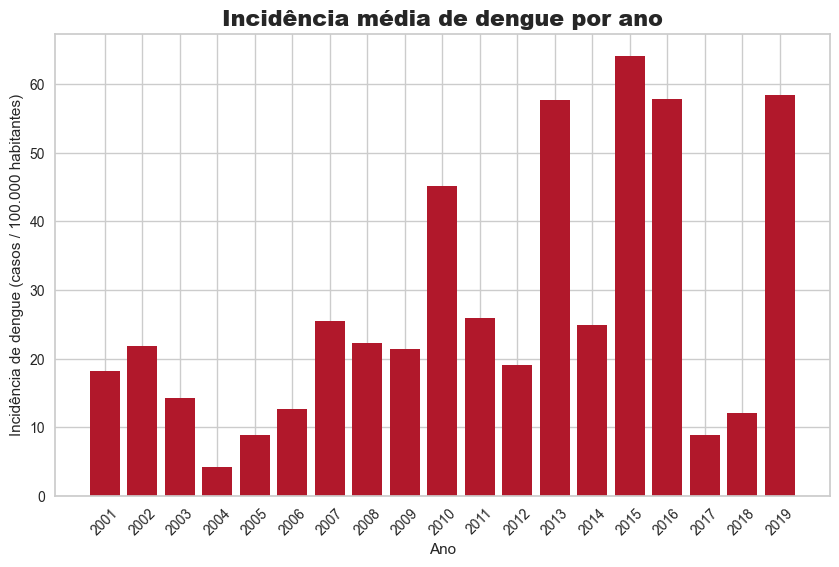

In [16]:
# Extrair o ano da coluna 'date'
df_dengue["year"] = df_dengue["date"].apply(lambda date: date.split("-")[0])

# Calcular a média da incidência de dengue por ano
media_incidencia_por_ano = df_dengue.groupby('year')['incidencia_dengue'].mean()

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(media_incidencia_por_ano.index, media_incidencia_por_ano.values, color='#b1182b')
plt.title('Incidência média de dengue por ano', fontweight=800, fontsize=16)
plt.xlabel('Ano')
plt.ylabel('Incidência de dengue (casos / 100.000 habitantes)')
plt.xticks(rotation=45)
plt.show()

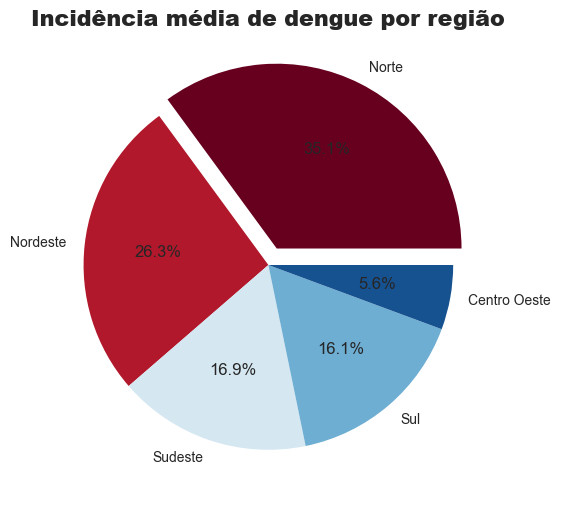

In [17]:
# Calcular a média da incidência de dengue por região
media_incidencia_por_regiao = df_dengue.groupby('region_name')['incidencia_dengue'].mean().sort_values(ascending=False)

# Plotar o gráfico de pizza
plt.figure(figsize=(10, 6))
plt.pie(
    media_incidencia_por_regiao,
    explode=[0.1] + [0] * (len(media_incidencia_por_regiao) - 1),
    labels=df_dengue["region_name"].unique(),
    colors=["#67001f", "#b1182b", "#d5e7f1", "#6eaed2", "#175290"],
    autopct="%1.1f%%",
)
plt.title('Incidência média de dengue por região', fontweight=800, fontsize=16)
plt.show()

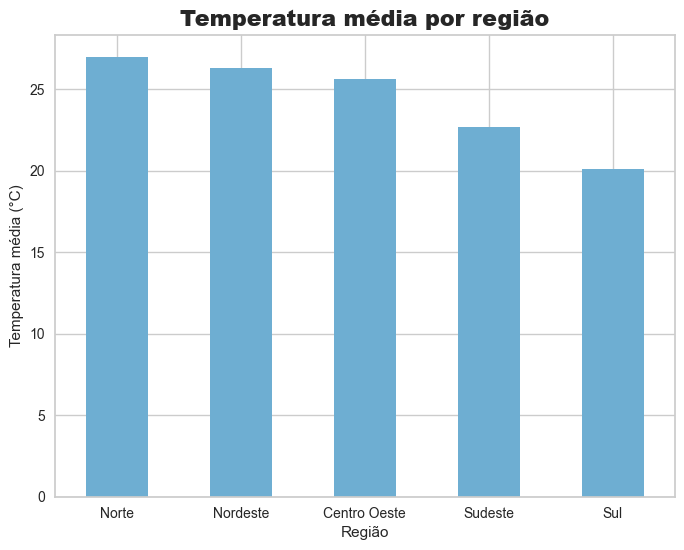

In [18]:
# Calcular a temperatura média (média entre a temperatura máxima e mínima)
df_dengue['mean_temperature'] = (df_dengue['tmax'] + df_dengue['tmin']) / 2

# Calcular a temperatura média de cada região
media_temperatura_por_regiao = df_dengue.groupby('region_name')['mean_temperature'].mean().sort_values(ascending=False)

# Plotar o gráfico de barras
plt.figure(figsize=(8, 6))
media_temperatura_por_regiao.plot(kind='bar', color='#6eaed2')
plt.title('Temperatura média por região', fontweight=800, fontsize=16)
plt.xlabel('Região')
plt.ylabel('Temperatura média (°C)')
plt.xticks(rotation=0)
plt.show()

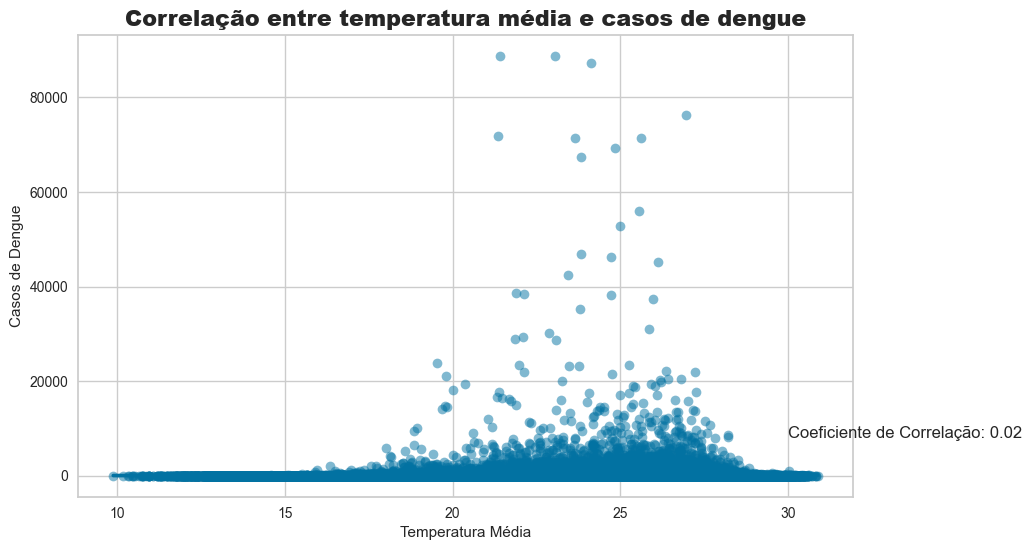

In [19]:
# Calcular o coeficiente de correlação entre a temperatura média e o número de casos de dengue
correlation = df_dengue['mean_temperature'].corr(df_dengue['dengue_cases'])

# Plotar o gráfico de dispersão e a linha de regressão
plt.figure(figsize=(10, 6))
sns.regplot(x='mean_temperature', y='dengue_cases', data=df_dengue, scatter_kws={'alpha':0.5})
plt.title('Correlação entre temperatura média e casos de dengue', fontweight=800, fontsize=16)
plt.xlabel('Temperatura Média')
plt.ylabel('Casos de Dengue')
plt.text(30, 8000, f'Coeficiente de Correlação: {correlation:.2f}', fontsize=12)
plt.show()

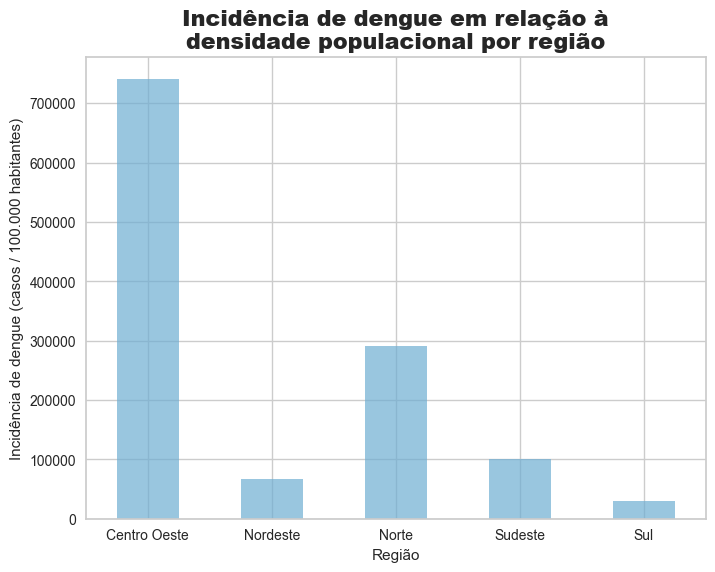

In [20]:
# Filtrar o número de população por região
df_populacao_regiao = df_dengue.groupby('region_name')['pop_density'].mean().sort_values(ascending=False)

# Filtrar a incidência de dengue por região
df_incidencia_regiao = df_dengue.groupby('region_name')['dengue_cases'].mean() / df_populacao_regiao * 100000

# Plotar o gráfico de barras
plt.figure(figsize=(8, 6))
df_incidencia_regiao.plot(kind='bar', color='#6eaed2', alpha=0.7)
plt.title('Incidência de dengue em relação à\ndensidade populacional por região', fontweight=800, fontsize=16)
plt.xlabel('Região')
plt.ylabel('Incidência de dengue (casos / 100.000 habitantes)')
plt.xticks(rotation=0)
plt.show()

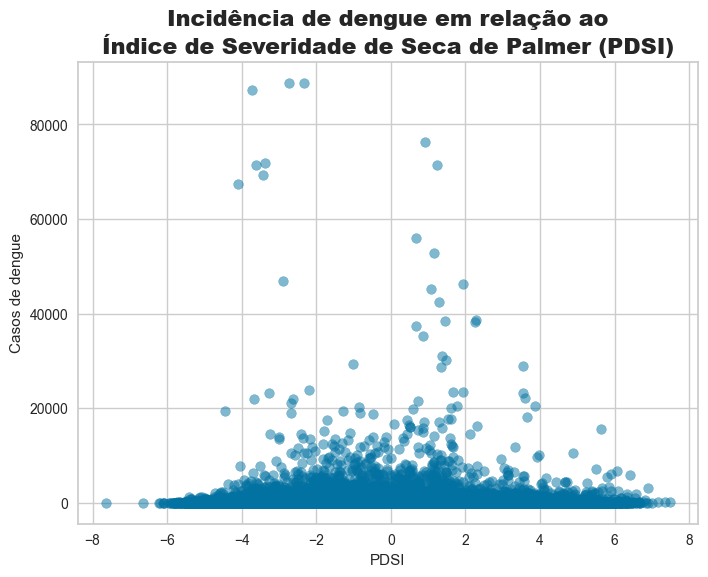

In [21]:
# Plotar o gráfico de dispersão
plt.figure(figsize=(8, 6))
plt.scatter(df_dengue['pdsi'], df_dengue['dengue_cases'], alpha=0.5)
plt.title('Incidência de dengue em relação ao\nÍndice de Severidade de Seca de Palmer (PDSI)', fontweight=800, fontsize=16)
plt.xlabel('PDSI')
plt.ylabel('Casos de dengue')
plt.show()

In [22]:
acum_dengue_regioes = df_dengue.groupby("region_name")["dengue_cases"].sum()
mapa_regiao = geobr.read_state()
mapa_dengue_regioes_acum = mapa_regiao.merge(acum_dengue_regioes, how="left", left_on="name_region", right_on="region_name")

In [23]:
acum_dengue_estados = df_dengue.groupby("state_name")["dengue_cases"].sum()
acum_dengue_estados = acum_dengue_estados.rename({"Espírito Santo": "Espirito Santo"})
mapa_estado = geobr.read_state()
mapa_dengue_estados_acum = mapa_estado.merge(acum_dengue_estados, how="left", left_on="name_state", right_on="state_name")

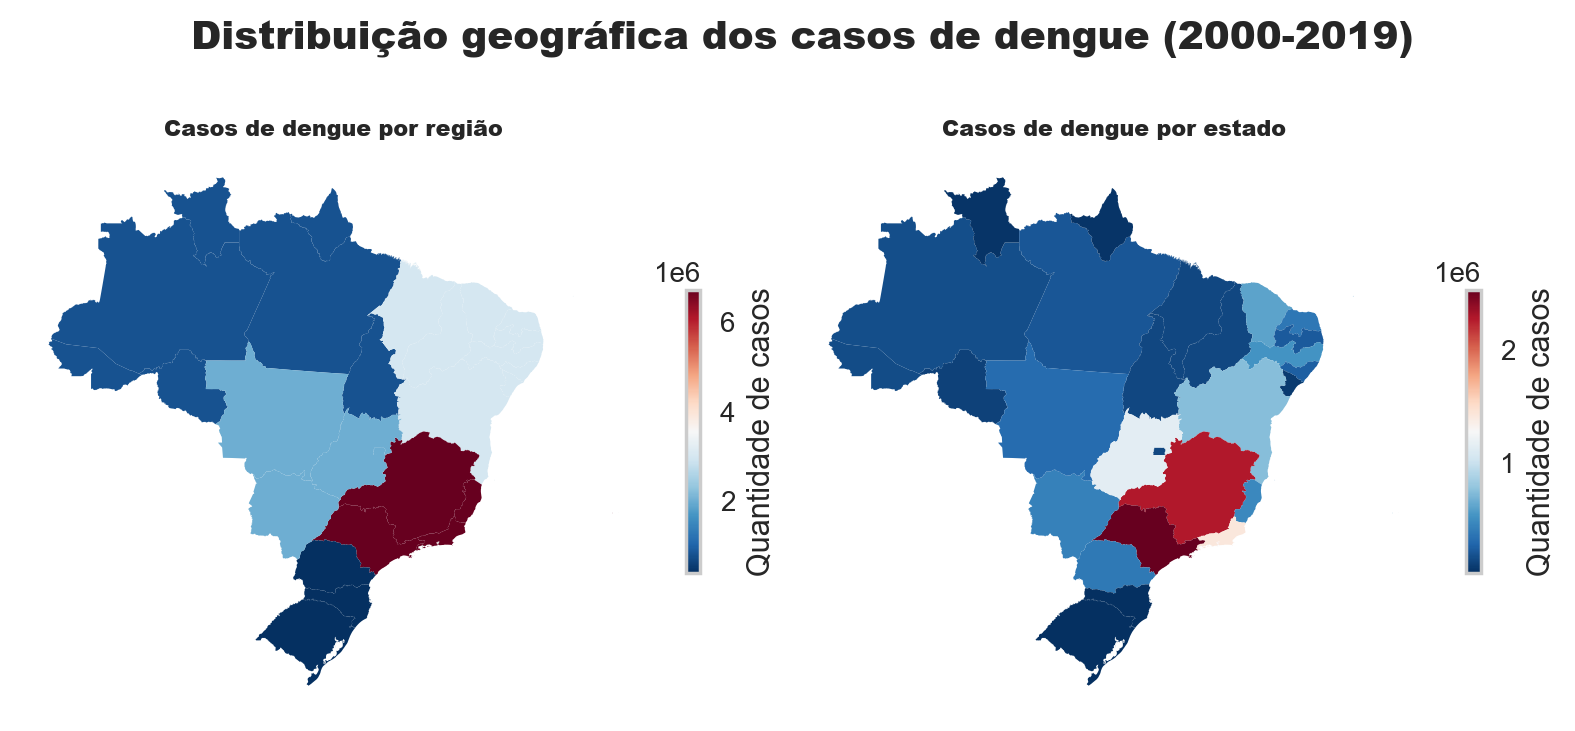

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4), dpi=200)

fig.suptitle("Distribuição geográfica dos casos de dengue (2000-2019)", fontweight=800, fontsize=14)

plot_mapa(mapa_dengue_regioes_acum, "dengue_cases", "Casos de dengue por região", "Quantidade de casos", ax1)
plot_mapa(mapa_dengue_estados_acum, "dengue_cases", "Casos de dengue por estado", "Quantidade de casos", ax2)

In [25]:
df_dengue.head()

,micro_name_ibge,state_name,region_name,ecozone_name,main_climate,time,dengue_cases,population,pop_density,tmax,...,pdsi,urban,water_network,water_shortage,date,uf,incidencia_dengue,month,year,mean_temperature
0,Porto Velho_RO,Rondônia,Norte,Amazônia,AM,13,267.0,426640.0,6.503234,30.180363,...,-0.311743,85.20,33.57,0.2245,2001-01-01,RO,62.582036,01,2001,25.826079
1,Guajará-Mirim_RO,Rondônia,Norte,Amazônia,AM,13,12.0,61321.0,1.504577,30.369087,...,-0.803746,72.31,27.43,0.0873,2001-01-01,RO,19.569152,01,2001,25.834784
2,Ariquemes_RO,Rondônia,Norte,Amazônia,AM,13,2.0,143809.0,5.903734,30.084492,...,-0.022145,66.91,27.76,0.1871,2001-01-01,RO,1.390734,01,2001,25.634169
3,Ji-Paraná_RO,Rondônia,Norte,Amazônia,AM,13,93.0,306896.0,12.241386,29.946037,...,-0.269979,68.68,32.23,0.2381,2001-01-01,RO,30.303425,01,2001,25.341459
4,Alvorada D'Oeste_RO,Rondônia,Norte,Amazônia,AM,13,1.0,74460.0,4.658250,29.965841,...,-1.247326,42.82,21.40,0.2837,2001-01-01,RO,1.343003,01,2001,25.310441


In [26]:
dengue_nas_regioes_ao_longo_dos_anos = df_dengue.groupby(["year", "region_name"])["dengue_cases"].sum().reset_index()

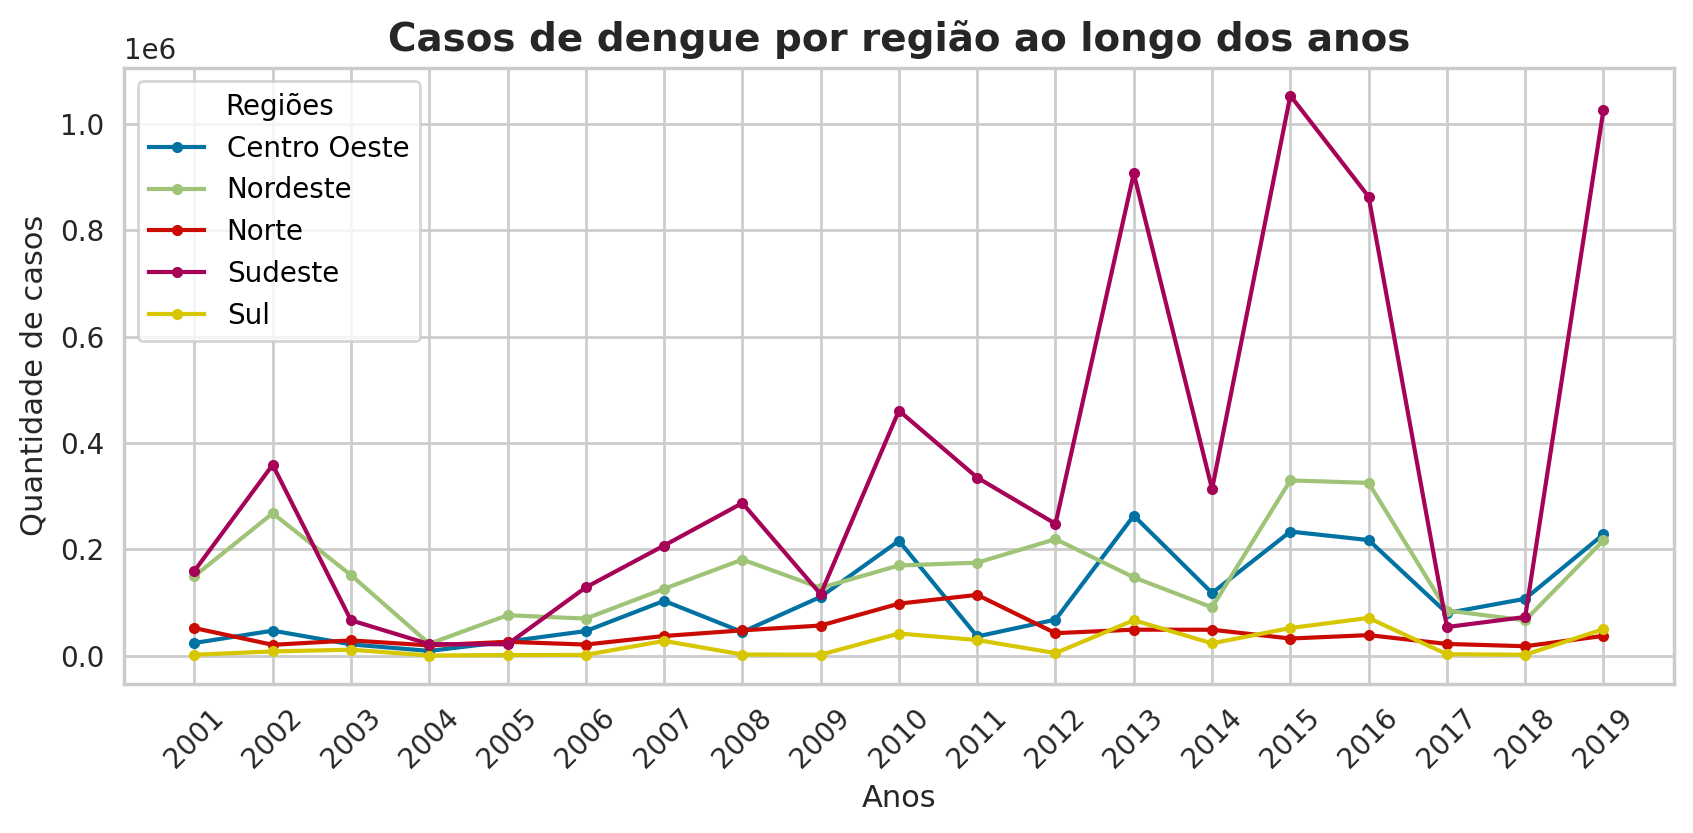

In [27]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=200)

plot_serie_temporal(
    dengue_nas_regioes_ao_longo_dos_anos,
    rotulo="dengue_cases", 
    coluna_tempo="year",
    coluna_legenda="region_name",
    titulo="Casos de dengue por região ao longo dos anos", 
    titulo_legenda="Regiões", 
    xlabel="Anos", 
    ylabel="Quantidade de casos", 
    ax=ax
)

plt.show()

In [28]:
correlation_matrix = df_dengue.select_dtypes(include='number').corr()

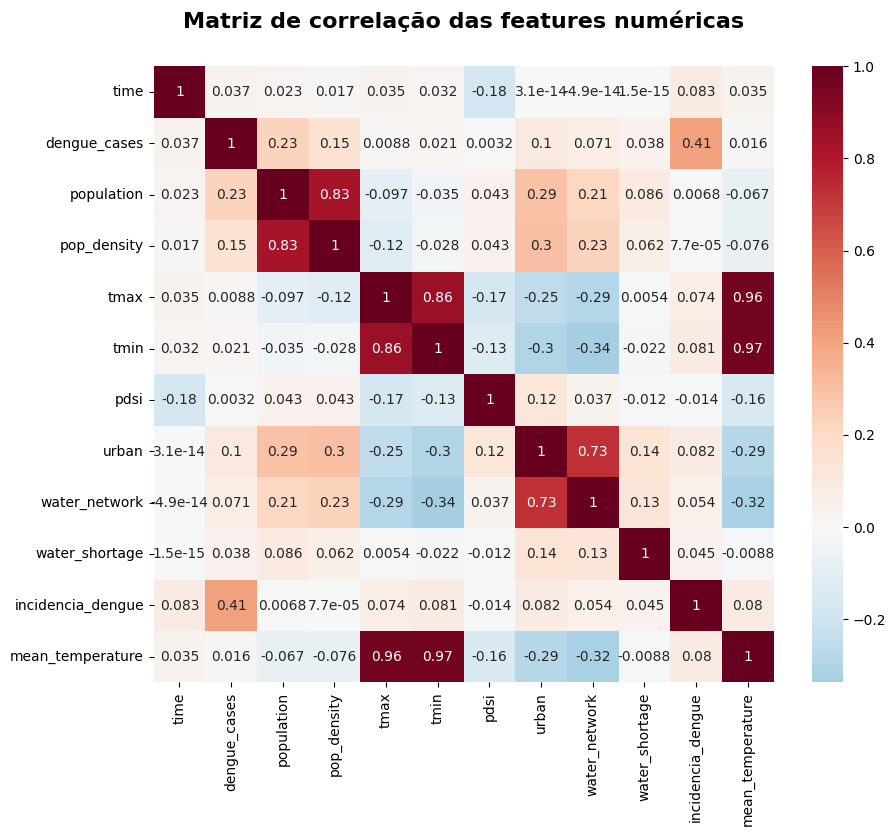

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0)
plt.title('Matriz de correlação das features numéricas', fontweight=800, fontsize=16, y=1.05)
plt.show()

###
## Machine Learning

In [30]:
df_dengue.drop(["date", "uf", "year", "incidencia_dengue", "month", "year", "mean_temperature"], axis=1, inplace=True)
X = pd.get_dummies(
    df_dengue,
    columns=['micro_name_ibge', 'state_name', 'region_name', 'ecozone_name', 'main_climate']
)

In [31]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(X)

In [32]:
principal_components = pca.components_
explained_variance = pca.explained_variance_ratio_
pc_df = pd.DataFrame(principal_components, columns=X.columns, index=['PC1', 'PC2'])

display(pc_df.T)

,PC1,PC2
time,1.723369e-06,2.288315e-03
dengue_cases,2.486660e-04,9.998689e-01
population,9.999999e-01,-2.431683e-04
pop_density,3.418866e-04,-1.601095e-02
tmax,-3.763116e-07,1.163507e-04
...,...,...
main_climate_BSH,-1.743958e-08,-8.916171e-07
main_climate_CFA,-5.148550e-10,-6.677568e-06
main_climate_CFB,3.448788e-08,-1.340773e-05
main_climate_CWA,-3.917478e-09,3.585089e-06


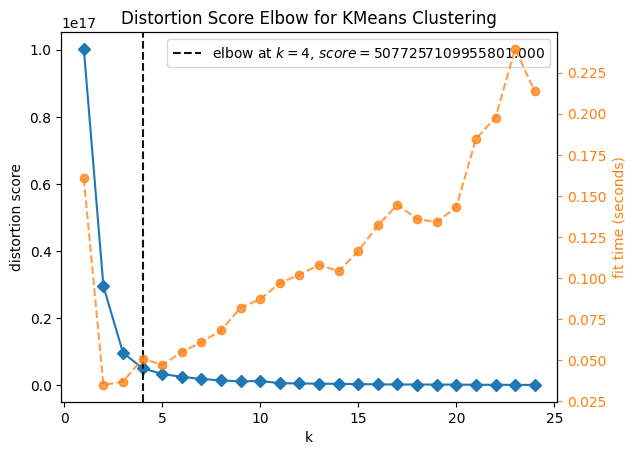

In [33]:
model = KMeans()
visualizer = KElbowVisualizer(model, k = (1, 25)).fit(df_pca)

visualizer.show()
plt.show()

In [34]:
model = KMeans(n_clusters=4, random_state=42).fit(df_pca)
clusters = model.predict(df_pca)

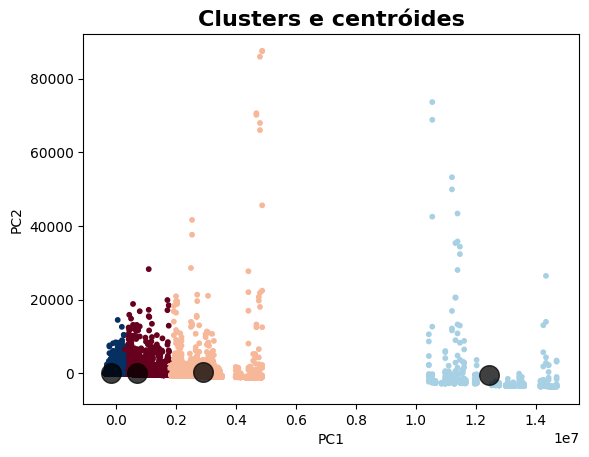

In [35]:
centros = model.cluster_centers_

plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, s=10, cmap='RdBu_r')
plt.scatter(centros[:, 0], centros[:, 1], c='black', s=200, alpha=0.75, marker='o')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters e centróides', fontweight=800, fontsize=16)
plt.show()